# PyVG: Data Science to predict Video Games sales
>Equipe: Alexis Terrasse, Henri-François Mole, Hsan Drissi, Stephane Lelievre
>
>Promo: DS_Oct21
---
## Analyse de sentiments

<img src='http://25.media.tumblr.com/274c599239708c7a99a59d33bfb4fd9f/tumblr_mh4dx55rzM1rb0elmo1_400.gif' width=500></img>

### Importation des bibliothèques

In [1]:
import pandas as pd  # Importation de pandas sous l'alias pd
import numpy as np  # Importation de Numpy sous l'alias np
import matplotlib.pyplot as plt  # Importation de Matplotlib sous l'alias plt
# Execution en ligne des graphiques
%matplotlib inline  
import seaborn as sns  # Importation de seaborn sous l'alias sns


from tqdm import tqdm  # Importation de tqdm
from joblib import dump # Importation de la méthode dump der joblib
import os # Importation de os


from wordcloud import WordCloud # Importation de WordCloud
import gensim # Importation de gensim
from gensim.models import KeyedVectors # Importation de KeyedVectors
import gensim.downloader as api # Importation de api

# Outils scikit learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Chargement des modèles de machine learning
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Chargement de tensorflow, keras etc...
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


# Chargement de warnings pour gérer les avertissements
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Chargement des fonctions utilitaires

In [2]:
from nlp_utils import *

### Chargement du dataset

<p>Pour cette partie du projet nous utiliserons les commentaires et notes utilisateurs récupérées sur le site Metacritic (en scraping). </p>

<p>Le dataset contient 1 624 963 lignes et est composé de 7 colonnes :
<ul>- <b>Name</b> : Le nom du jeu - type object</ul>
    <ul>- <b>Platform</b> : La plateforme du jeu - type object</ul>
    <ul>- <b>Genre</b> : Le genre du jeu - type object</ul>
    <ul>- <b>Date_crit</b> : La date de la critique - type object</ul>
    <ul>- <b>Name_crit</b> : Le nom de l'utilisateur - type object</ul>
    <ul>- <b>Score_crit</b> : Le score donné par l'utilisateur (entier compris 0 et 10) - type int</ul>
    <ul>- <b>Comment_crit</b> : Le commentaire laissé par l'utilisateur - type object</ul>
</p>

<p>Le dataset ne contient pas de valeures manquantes.</p>
    
<p>Nous nous intêresserons ici uniquement au lien entre le commentaire laissé par l'utilisateur (Comment_crit) et le score (Score_crit). </p>

<p>Score_crit sera notre variable cible et il faudra donc transformer les commentaires (Comment_crit) en features à l'aide des outils de Natural Language Processing (NLP) afin pouvoir utiliser des modèles de classification pour prédire un score utilisateur en fonction d'une critique.</p>

<p>Cela nous servira par la suite à prédire le score d'un jeu n'étant pas encore sorti en fonction des critiques/commentaires disponibles en ligne (Reddit, Twitter, etc...).</p>


In [3]:
# Chargement du dataset dans le dataframe df
df= pd.read_csv('https://www.dropbox.com/s/h92o7e3504mqfon/usereviews.zip?dl=1', compression='zip')

# Affichage des dimension du dataframe
print('Dimension de df: ', df.shape)

# Affichage des premières lignes du dataframe
df.head()

Dimension de df:  (1624963, 7)


,Name,Platform,Genre,Date_crit,Name_crit,Score_crit,Comment_crit
0,Full Throttle,PC,"Adventure, General","Feb 4, 2004",NicolasV.,10,Do you like adventure games? THEN GET THIS ONE!
1,Full Throttle,PC,"Adventure, General","Sep 30, 2007",DaveW.,10,I got this game when it first came out and I w...
2,Full Throttle,PC,"Adventure, General","Aug 31, 2005",AlejandroD.,10,This is one of the best games ever!!! A classi...
3,Full Throttle,PC,"Adventure, General","Dec 14, 2007",KrzysztofP.,10,My sister brought it onced when we were kids. ...
4,Full Throttle,PC,"Adventure, General","Oct 17, 2012",jerrypatel_07,10,This is the first adventure game i had played....


In [4]:
# On ne conserve que les deux colonnes qui nous intéressent pour ce travail, c-a-d, Comment_crit et Score_crit
df=df[['Comment_crit', 'Score_crit']]

# On extrait les méta-données, à l'aide de la fonction RetrieveMetaData, pour chaque critique et on les ajoutent à df
df= RetrieveMetaData(df, col_name='Comment_crit')

Ajout de la colonne nb_sentences: 100%|██████████| 1624963/1624963 [00:37<00:00, 43675.93it/s]


In [5]:
# Affichage des valeures maximales pour nb_caracter/nb_words/nb_sentences
print('Valeures maximales pour nb_caracter: {}, nb_words: {}, nb_sentences: {}'.format(
                                                                            df['nb_caracter'].max(),
                                                                            df['nb_words'].max(), 
                                                                            df['nb_sentences'].max()))
# Analyse des valeurs moyennes des méta-données par scores
df.iloc[:,1:].groupby(['Score_crit']).mean()

Valeures maximales pour nb_caracter: 329421, nb_words: 23433, nb_sentences: 1250


,links,mails,quotes,hashtags,capslock,chain_capslock,exclamations,chain_exclamation,interogation,etc,nb_caracter,nb_words,nb_sentences
Score_crit,,,,,,,,,,,,,
0,0.005360,0.001160,0.002234,0.016416,12.673766,1.595683,0.709752,0.072833,0.322524,0.284904,394.688139,70.212530,4.549856
1,0.003493,0.000526,0.001390,0.005612,15.373328,1.766255,0.596596,0.066697,0.393012,0.409406,545.034264,97.860129,6.039655
2,0.003400,0.000499,0.001664,0.006087,19.004137,2.065121,0.470328,0.048716,0.440252,0.471446,720.024061,129.611127,7.675725
3,0.002906,0.000484,0.000923,0.004912,19.729214,2.014530,0.443114,0.044443,0.421389,0.468161,788.628289,141.738232,8.195484
4,0.002973,0.000422,0.001054,0.004111,21.005271,2.046762,0.397411,0.039214,0.434475,0.475734,853.633918,153.304583,8.695100
5,0.003254,0.000611,0.001582,0.004242,19.657726,1.822643,0.342022,0.032160,0.362371,0.438233,823.276102,148.196915,8.335730
6,0.005962,0.000296,0.001396,0.003646,20.355889,1.770690,0.287188,0.026098,0.307208,0.458489,883.972096,158.598404,8.665347
7,0.005070,0.000448,0.001130,0.003592,18.437748,1.499636,0.279425,0.022483,0.221375,0.395277,814.438901,146.674691,7.795669
8,0.007522,0.000158,0.001036,0.002735,16.576698,1.343845,0.345430,0.024328,0.158442,0.284616,717.033025,128.653882,6.962643


In [6]:
# Nettoyage des critiques (suppression des liens, des hashtags, des adresses email, de laponctuation, des stopwords et passage en caractères minuscules
tqdm.pandas(desc='Nettoyage des commentaires')  # Barre de progression du processus de nettoyage
df['Comment_clean']= df['Comment_crit'].progress_apply(lambda x: ' '.join(review_wordlist(x,True)))

Nettoyage des commentaires: 100%|██████████| 1624963/1624963 [13:02<00:00, 2077.36it/s]


In [7]:
#nltk.download('stopwords')

### Affichage d'un Nuage de mots

<p>Avant d'aller plus en avant nous allons faire une représentation sous forme de nuage de mots de notre corpus de critiques</p>

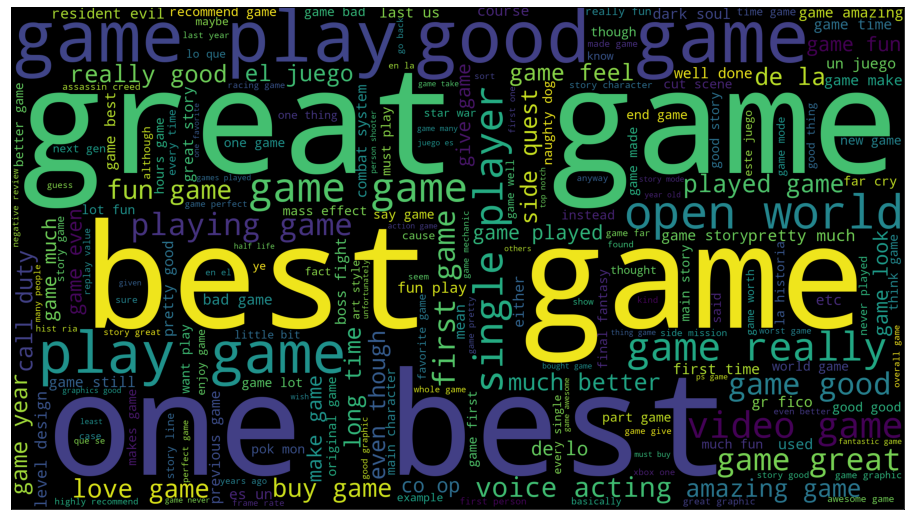

In [7]:
from wordcloud import WordCloud
# On récupère toutes les critiques nettoyées que l'on concatène dans une seul et même chaine de caractères
reviews_sample = df['Comment_clean'].values
reviews_sample = ' '.join(reviews_sample)

# Instanciation et création du nuage de mots avec notre corpus
wordcloud = WordCloud(width=2560, height=1440, 
                        background_color='black',
                        min_font_size=10)
word_cloud = wordcloud.generate(reviews_sample)

# Affichage du nuage de mots
plt.figure(figsize=(16,10))
plt.imshow(word_cloud)
plt.xticks([])
plt.yticks([])
plt.grid(False)
filename= 'wordcloud.png'
plt.savefig(filename)

### Réduction et ré-équilibrage du jeu de données

In [8]:
# Pour des raisons pratiques on réduit le dataframe aux critiques de 500 mots ou moins
df_reduced=df[df['nb_words'] <= 500]
df_reduced= df_reduced.dropna()
print('Dimensions de df_reduced:', df_reduced.shape)

Dimensions de df_reduced: (1582600, 16)


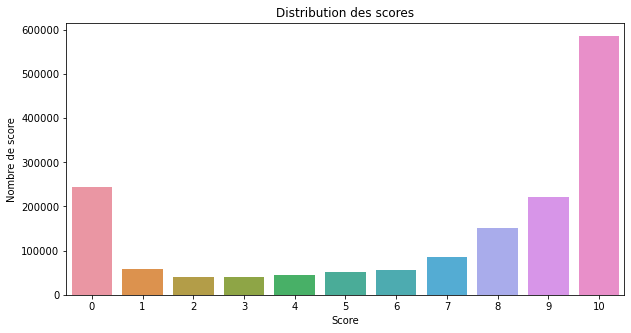

In [9]:
# Affichage de la distribution des scores de df
plt.figure(figsize=(10,5))
sns.countplot(data=df_reduced, x= 'Score_crit')
plt.xlabel('Score')
plt.ylabel('Nombre de score')
plt.title('Distribution des scores')
plt.savefig('distrib_score.png');

<p>On remarque à l'aide de la figure ci-dessus que le nombre pour chaque scores n'est pas le même d'un score à un autre.</p>

<p>Le dataset étant très volumineux et déséquilibré, nous allons donc procéder à un ré-échantillonnage par rapport à la variable Score_crit. 
On ne conservera qu'un échantillon de 40000 individus pour chaque modalité de Score_crit.</p>


Dimension de df_strat:  (440000, 16)


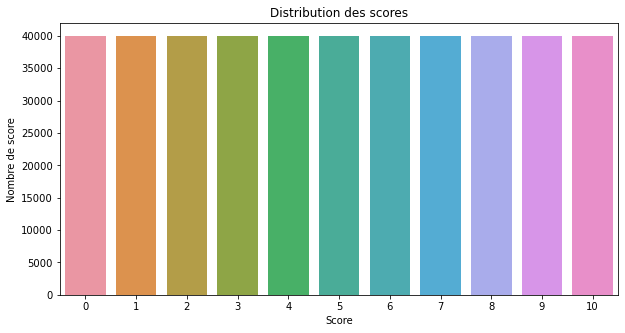

In [10]:
# Ré-échantillonnage/équilibrage du dataset à l'aide de la fonction stratified_sample
df_strat= stratified_sample(df_reduced,'Score_crit', 40000)

# Affichage des dimensions de df_strat
print('Dimension de df_strat: ', df_strat.shape)

# Affichage de la distribution des scores de df
plt.figure(figsize=(10,5))
sns.countplot(data=df_strat, x= 'Score_crit')
plt.xlabel('Score')
plt.ylabel('Nombre de score')
plt.title('Distribution des scores')
plt.savefig('distrib_score_eq.png');

In [28]:
#### Point de sauvegarde  ####
df_strat.to_csv('sa_meta_clean_strat.csv', sep=",", encoding='utf-8', index=False)

In [14]:
#### Chargement de notre jeu de données modifié ####
df_strat= pd.read_csv('sa_meta_clean_strat.csv')

### Séparation du jeu de données et normalisation des metadonnées

In [11]:
# Séparation du jeu de données en jeu d'entrainement et jeu de test (20%)
X_train, X_test, y_train, y_test = train_test_split(df_strat.drop('Score_crit', axis=1),df_strat['Score_crit'], test_size = 0.20)
print('Dimensions de X_train:', X_train.shape)
print('Dimensions de X_test:', X_test.shape)

Dimensions de X_train: (352000, 15)
Dimensions de X_test: (88000, 15)


In [12]:
# Standardisation des méta-données
# Instanciation de l'objet StandardScaler
scaler= StandardScaler()

# fit_transform sur le jeu d'entrainement et transform sur le jeu de test
train_meta_scaled= scaler.fit_transform(X_train.drop(['Comment_crit','Comment_clean'], axis=1))
test_meta_scaled= scaler.transform(X_test.drop(['Comment_crit','Comment_clean'], axis=1))

# Sauvegarde de l'objet standardscaler
dump(scaler,'standardscaler.sav')

['standardscaler.sav']

### Bag of Words

In [13]:
# Instanciation d'un objet TfidfVectorizer de dimension 1000
tfidf_vec = TfidfVectorizer(min_df = 0,  max_features=1000)  

# Transformation de X_train et X_test sous forme de vecteurs à l'aide de tfidf_vec
X_train_bow = tfidf_vec.fit_transform(X_train['Comment_clean']) # fit train
X_test_bow = tfidf_vec.transform(X_test['Comment_clean']) # transform test

In [14]:
# Ajout des métadonnées normalisées
X_train_bow= np.hstack((train_meta_scaled,X_train_bow.toarray()))
X_test_bow= np.hstack((test_meta_scaled,X_test_bow.toarray()))

# Affichage des dimensions de X_train_bow et X_test_bow
print('Dimensiosn de X_train_bow', X_train_bow.shape)
print('Dimensiosn de X_test_bow', X_test_bow.shape)

Dimensiosn de X_train_bow (352000, 1013)
Dimensiosn de X_test_bow (88000, 1013)


In [15]:
# On sauvegarde l'objet TfidfVectorizer
#dump(tfidf_vec, 'tfidf_vec.sav')

['tfidf_vec.sav']

##### Decision Tree Classifier

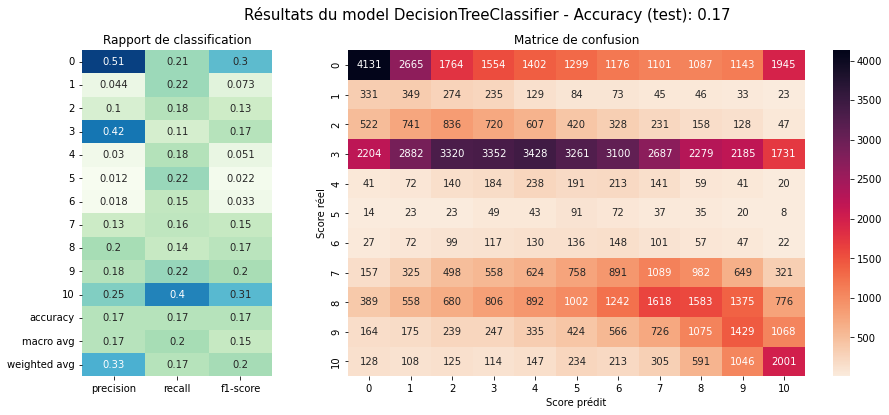

In [16]:
bow_dtc = DecisionTreeClassifier(max_depth=8)
bow_dtc.fit(X_train_bow, y_train)
display_results(bow_dtc,X_test_bow,y_test,oh= False)

##### Logistic Regression

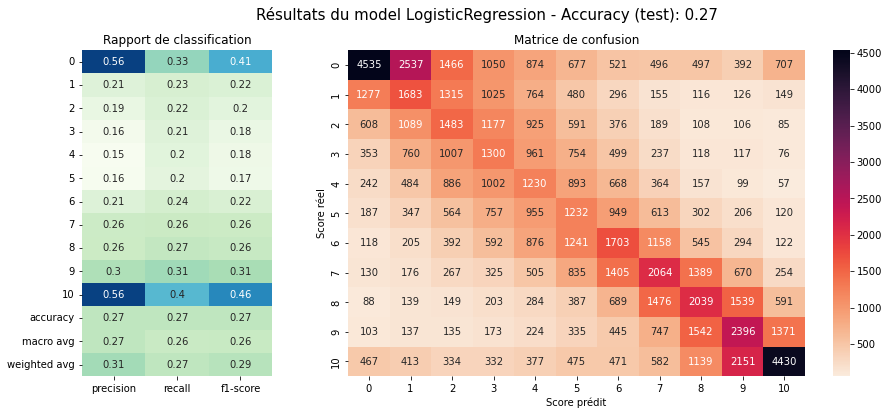

In [17]:
bow_lg = LogisticRegression()
bow_lg.fit(X_train_bow, y_train)
display_results(bow_lg,X_test_bow,y_test,oh= False)

###### AdaBoost Classifier

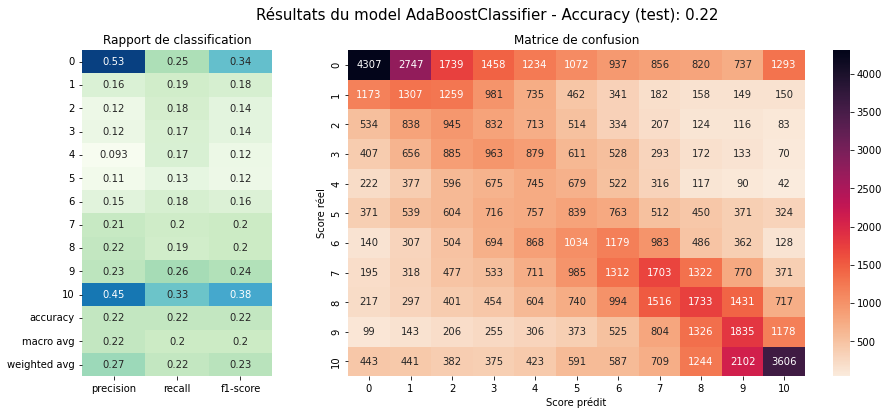

In [18]:
bow_abc = AdaBoostClassifier()
bow_abc.fit(X_train_bow, y_train)
display_results(bow_abc,X_test_bow,y_test,oh= False)

##### DNN 2-layers

In [19]:
# One-hot encoding de y_train et y_test
y_train_oh= to_categorical(y_train, dtype = 'int')
y_test_oh = to_categorical(y_test, dtype = 'int')

# Instanciation de TimingCallback, EarlyStopping et ReduceLROnPlateau pour contrôler le modèle

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping= EarlyStopping(monitor = 'val_loss',
                              min_delta = 0.01,
                              patience = 5,
                              mode = 'min',
                              verbose = 1)

reduce_learning_rate= ReduceLROnPlateau(monitor = 'val_loss',
                                        min_delta = 0.01,
                                        patience = 3,
                                        factor = 0.1, 
                                        cooldown = 4,
                                        verbose = 1)

time_callback= TimingCallback()

# Définition du modèle à base de neurones denses
bow_dnn = Sequential(name="BoW-DNN")

bow_dnn.add(layers.Dense(1013, 
                         input_shape=(X_train_bow.shape[1],),
                         activation='relu',                     
                         activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)))

bow_dnn.add(layers.Dense(11, activation='sigmoid'))

# Compilation du modèle
bow_dnn.compile(loss='categorical_crossentropy', 
                optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),  
                metrics=['accuracy'])

# Sommaire du modèle
bow_dnn.summary()

Model: "BoW-DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1013)              1027182   
_________________________________________________________________
dense_1 (Dense)              (None, 11)                11154     
Total params: 1,038,336
Trainable params: 1,038,336
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Entrainement du modèle
bow_dnn_history= bow_dnn.fit(X_train_bow, y_train_oh, 
                         batch_size=128, epochs=40,
                         callbacks = [reduce_learning_rate,
                                                early_stopping,
                                                time_callback],
                         verbose=2, validation_data=(X_test_bow, y_test_oh))

Epoch 1/40
2750/2750 - 10s - loss: 1.9628 - accuracy: 0.2734 - val_loss: 1.9078 - val_accuracy: 0.2887
Epoch 2/40
2750/2750 - 7s - loss: 1.8508 - accuracy: 0.3302 - val_loss: 1.8523 - val_accuracy: 0.3304
Epoch 3/40
2750/2750 - 7s - loss: 1.6748 - accuracy: 0.4266 - val_loss: 1.7667 - val_accuracy: 0.3847
Epoch 4/40
2750/2750 - 7s - loss: 1.4455 - accuracy: 0.5313 - val_loss: 1.7039 - val_accuracy: 0.4236
Epoch 5/40
2750/2750 - 7s - loss: 1.2409 - accuracy: 0.6109 - val_loss: 1.6785 - val_accuracy: 0.4477
Epoch 6/40
2750/2750 - 7s - loss: 1.0698 - accuracy: 0.6736 - val_loss: 1.6888 - val_accuracy: 0.4696
Epoch 7/40
2750/2750 - 7s - loss: 0.9295 - accuracy: 0.7253 - val_loss: 1.7206 - val_accuracy: 0.4814
Epoch 8/40
2750/2750 - 7s - loss: 0.8102 - accuracy: 0.7683 - val_loss: 1.7547 - val_accuracy: 0.4955

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/40
2750/2750 - 7s - loss: 0.6019 - accuracy: 0.8530 - val_loss: 1.7186 - val_accuracy: 0.5084

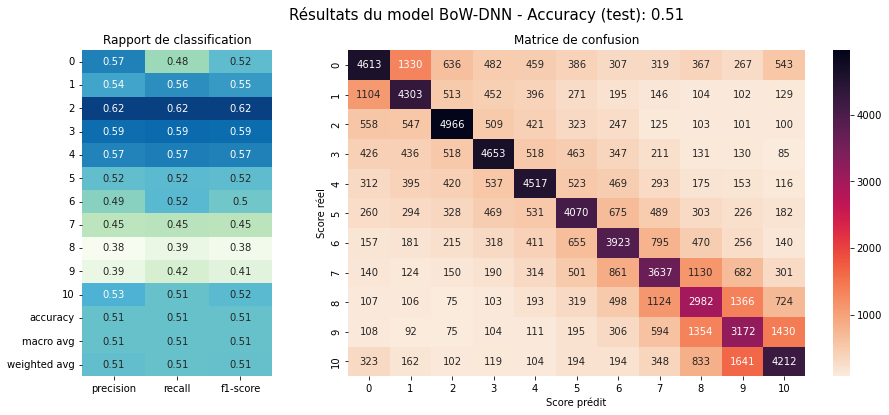

In [21]:
display_results(bow_dnn,X_test_bow,y_test,oh= True)

In [ ]:
# Sauvegarde du modèle
#bow_dnn.save('bow_dnn.h5')

In [22]:
# Libération mémoire graphique (si keras-gpu environnement utilisé)
reset_keras()

45628


### Word Embedding

Nous allons commencer par créer notre propre modèle d'embedding à l'aide de l'intégralité des critiques présentent dans le dataset.
Nous serons ainsi en mesure de transformer/vectoriser les critiques à l'aide du modèle d'embedding.
Une fois les critiques vectorisées on pourra alors tester des modèles de classification afin de prédire le score d'une critique.

In [23]:
## Chargement ou telechargement du model word2vec-google-news-300

# Récupération du chemin de téléchargement du model en local
path= gensim.downloader.BASE_DIR+'/word2vec-google-news-300/word2vec-google-news-300.gz'

#Si le fichier n'existe pas on le télécharge avec l'api
if not os.path.exists(path) :
    api.load("word2vec-google-news-300")
    
# Chargement du model limité aux 350 000 mots les plus fréquents 
emb_model = KeyedVectors.load_word2vec_format(path, binary=True, limit=350000)  

In [24]:
# On teste le model pour le terme MMORPG
emb_model['MMORPG']

array([ 0.56640625, -0.29296875, -0.00332642,  0.04638672, -0.24707031,
        0.20605469,  0.27734375, -0.0402832 ,  0.09277344,  0.00361633,
        0.0859375 ,  0.10253906,  0.2890625 ,  0.0480957 ,  0.22070312,
        0.26367188,  0.04931641,  0.16601562, -0.00549316, -0.18554688,
        0.23339844, -0.04907227,  0.40039062, -0.1796875 , -0.10009766,
        0.26757812,  0.19726562,  0.3125    , -0.10498047, -0.14550781,
       -0.1640625 , -0.01623535,  0.26757812, -0.03735352, -0.10449219,
       -0.10791016,  0.02880859, -0.05493164,  0.09179688,  0.04003906,
        0.234375  , -0.20410156, -0.05102539,  0.6796875 , -0.00830078,
       -0.35546875, -0.05224609, -0.05273438,  0.125     , -0.32226562,
       -0.00872803, -0.03491211, -0.07373047,  0.12988281, -0.06396484,
        0.22949219, -0.06347656,  0.21875   , -0.05883789, -0.32617188,
       -0.09326172,  0.14550781,  0.03149414, -0.10498047, -0.328125  ,
        0.12988281,  0.0546875 , -0.04882812, -0.06835938,  0.25

In [25]:
# Affichage des mots les plus proches de 'MMORPG'
emb_model.most_similar(['MMORPG'])

[('MMO', 0.875461995601654),
 ('MMOG', 0.8456364274024963),
 ('MMOs', 0.7930032014846802),
 ('MMORPGs', 0.789522111415863),
 ('massively_multiplayer', 0.7760448455810547),
 ('massively_multiplayer_online', 0.7448645234107971),
 ('Guild_Wars', 0.7323040962219238),
 ('MMOGs', 0.7185892462730408),
 ('Warcraft', 0.7158335447311401),
 ('Aion', 0.7087168097496033)]

In [26]:
# On stocke le vocabulaire dans vocab
vocab = emb_model.index_to_key

# On instancie un objet Tokenizer (keras.preprocessing.text)
t = Tokenizer()

# On récupère tous les mots de notre vocabulaire sous forme de liste
all_words=list(vocab)

# On calcule la taille de notre vocabulaire (on ajoute +1 pour la réservation de l'index 0)
vocab_size = len(all_words) +1

# On 'fit' le Tokenizer avec la liste de mots
t.fit_on_texts(all_words)

# On instancie la matrice d'embedding à l'aide de la fonction get_weight_matrix et on la stocke dans embedding_matrix
embedding_matrix = get_weight_matrix(emb_model,all_words,vocab_size)

Création de la matrice d'Embedding: 100%|██████████| 350000/350000 [14:25<00:00, 404.56it/s] 


In [27]:
# Vectorisation des critiques de X_train
X_train_emb= []
for review in tqdm(X_train['Comment_crit'],desc='Vectorisation des critiques de X_train'):
    X_train_emb.append(featureVecMethod(review.lower().split(),emb_model, 300))

# Vectorisation des critiques de X_test
X_test_emb= []
for review in tqdm(X_test['Comment_crit'],desc='Vectorisation des critiques de X_test'):
    X_test_emb.append(featureVecMethod(review.lower().split(),emb_model, 300))

Vectorisation des critiques de X_test: 100%|██████████| 88000/88000 [50:26<00:00, 29.08it/s]  


In [28]:
# Convertion de X_train_emb et X_test_emb sous forme de array
X_train_emb= np.array(X_train_emb)
X_test_emb= np.array(X_test_emb)

# Ajout des métadonnées
X_train_emb= np.hstack((train_meta_scaled,X_train_emb))
X_test_emb= np.hstack((test_meta_scaled,X_test_emb))

#Affichage des dimensions de X_train_emb et X_test_emb
print('Dimensiosn de X_train_emb', X_train_emb.shape)
print('Dimensiosn de X_test_emb', X_test_emb.shape)

Dimensiosn de X_train_emb (352000, 313)
Dimensiosn de X_test_emb (88000, 313)


###### Decision Tree Classifier

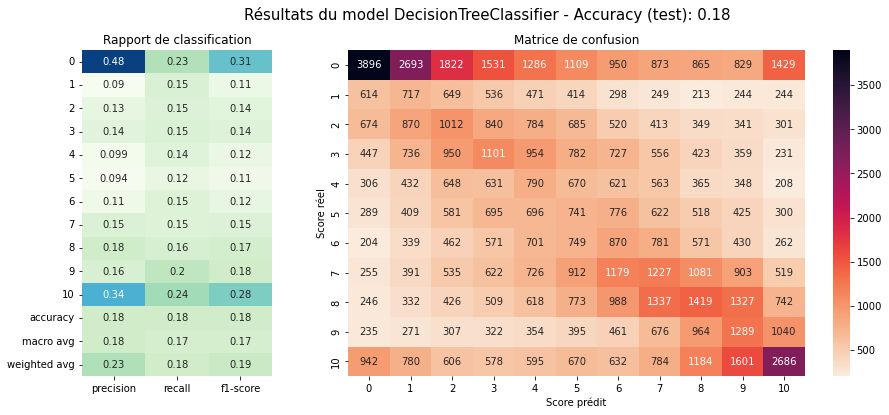

In [29]:
# Instanciation d'un model DecisionTreeClassifier de profondeur max = 8
emb_dtc = DecisionTreeClassifier(max_depth=8)

# Entrainement du model
emb_dtc.fit(X_train_emb, y_train)

# Affichage des résultats du model sur le jeu de test
display_results(emb_dtc,X_test_emb,y_test,oh= False)

###### Logistic Regression

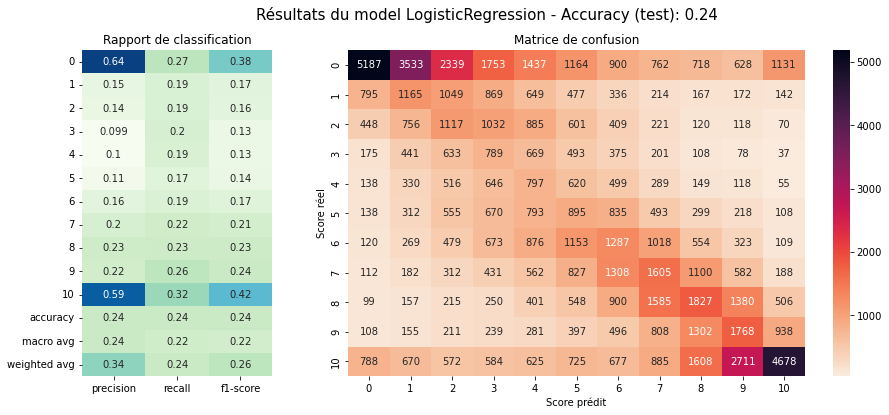

In [30]:
# Instanciation d'un model LogisticRegression 
emb_lg = LogisticRegression()

# Entrainement du model
emb_lg.fit(X_train_emb, y_train)

# Affichage des résultats du model sur le jeu de test
display_results(emb_lg,X_test_emb,y_test,oh= False)

###### AdaBoost Classifier

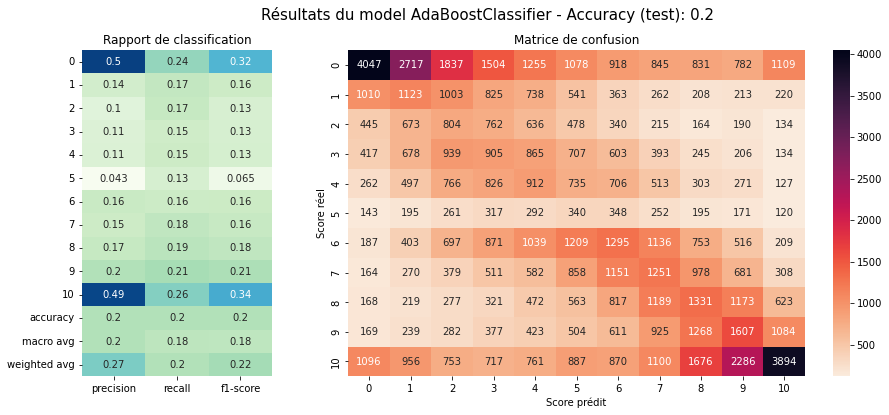

In [31]:
# Instanciation d'un model AdaBoostClassifier 
emb_abc= AdaBoostClassifier()

# Entrainement du model
emb_abc.fit(X_train_emb, y_train)

# Affichage des résultats du model sur le jeu de test
display_results(emb_abc,X_test_emb,y_test,oh= False)

###### Conv1DNN

In [32]:
# One-hot encoding de y_train et y_test
y_train_oh= to_categorical(y_train, dtype = 'int')
y_test_oh = to_categorical(y_test, dtype = 'int')

# Instanciation de TimingCallback, EarlyStopping et ReduceLROnPlateau pour contrôler le modèle

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping= EarlyStopping(monitor = 'val_loss',
                              min_delta = 0.01,
                              patience = 5,
                              mode = 'min',
                              verbose = 1)

reduce_learning_rate= ReduceLROnPlateau(monitor = 'val_loss',
                                        min_delta = 0.01,
                                        patience = 3,
                                        factor = 0.1, 
                                        cooldown = 4,
                                        verbose = 1)

time_callback= TimingCallback()

In [33]:
# Transforme chaque critique sous la forme d'une séquence d'entiers
X_train_seq=t.texts_to_sequences(X_train['Comment_crit'])
X_test_seq= t.texts_to_sequences(X_test['Comment_crit'])

# Transforme les séquences d'entiers des critiques obtenus précédement en vecteur de longueur maxlen (500)
maxlen = 500
X_train_emb2 = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_test_emb2 = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

In [35]:
# Instanciation du model avec Sequential puis ajout des différents layers avec .add
emb_conv1dnn = Sequential(name='Emb-Conv1DNN')

emb_conv1dnn.add(layers.Embedding(vocab_size, 
                           output_dim=emb_model.vector_size, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))

emb_conv1dnn.add(layers.Conv1D(250, 5, activation='relu'))
emb_conv1dnn.add(layers.GlobalMaxPool1D())
emb_conv1dnn.add(layers.Dense(250, activation='relu'))
emb_conv1dnn.add(layers.Dense(11,activation='softmax'))

# Compilation du model
emb_conv1dnn.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Sommaire du model
emb_conv1dnn.summary()

Model: "Emb-Conv1DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          105000300 
_________________________________________________________________
conv1d (Conv1D)              (None, 496, 250)          375250    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               62750     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                2761      
Total params: 105,441,061
Trainable params: 105,441,061
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Entrainement du model sur 40 epochs et un batch de taille 128
history = emb_conv1dnn.fit(X_train_emb2, y_train_oh,
                    epochs=40,
                    validation_data=(X_test_emb2, y_test_oh),
                    callbacks = [reduce_learning_rate,
                                 early_stopping,
                                 time_callback],
                    batch_size=128)

Epoch 1/40
2750/2750 [==============================] - 246s 83ms/step - loss: 1.8005 - accuracy: 0.3220 - val_loss: 1.6655 - val_accuracy: 0.3774
Epoch 2/40
2750/2750 [==============================] - 218s 79ms/step - loss: 1.4496 - accuracy: 0.4721 - val_loss: 1.5333 - val_accuracy: 0.4587
Epoch 3/40
2750/2750 [==============================] - 222s 81ms/step - loss: 1.0472 - accuracy: 0.6307 - val_loss: 1.5262 - val_accuracy: 0.5100
Epoch 4/40
2750/2750 [==============================] - 222s 81ms/step - loss: 0.7178 - accuracy: 0.7521 - val_loss: 1.6988 - val_accuracy: 0.5377
Epoch 5/40
2750/2750 [==============================] - 223s 81ms/step - loss: 0.5094 - accuracy: 0.8261 - val_loss: 1.9933 - val_accuracy: 0.5467

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/40
2750/2750 [==============================] - 221s 81ms/step - loss: 0.2753 - accuracy: 0.9113 - val_loss: 2.3031 - val_accuracy: 0.5616
Epoch 7/40
2750/2750 [==============

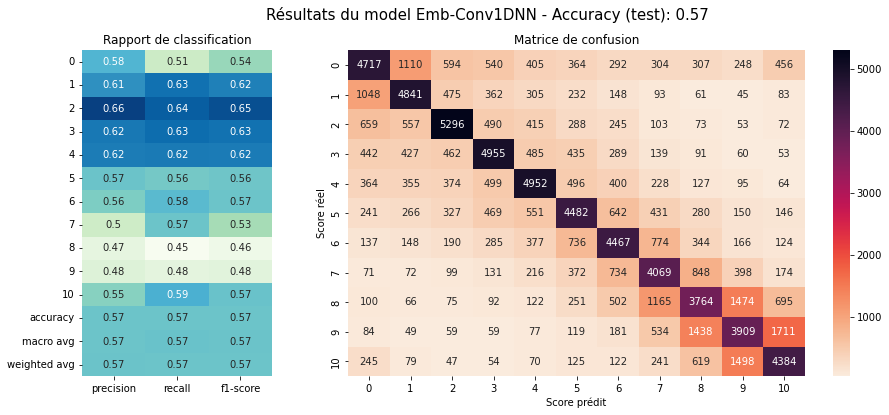

In [37]:
# Affichage des résultats du model
display_results(emb_conv1dnn,X_test_emb2,y_test,oh= True)

In [38]:
# Sauvegarde du modèle
emb_conv1dnn.save('emb_conv1dnn.h5')

In [39]:
# Libération mémoire graphique (si keras-gpu environnement utilisé)
reset_keras()

27160
